# RNN 1D Localization task.

In [1]:
import torch
import random
from math import pi

class Network(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(n_input, n_hidden, batch_first=True)
        self.linear = torch.nn.Linear(n_hidden, n_output)
        self.tanh = torch.nn.Tanh()
    
    def forward(self, input):
        return self.tanh(self.linear(self.rnn(input)[0]))

def vonMises(x, sigma):
    """The PDF of a von Mises distribution centered on 0."""
    return torch.exp((torch.cos(x)-1)/(2*sigma**2))

def circular(theta):
    """Wraps `theta` to [-pi,pi)."""
    return (theta+pi)%(2*pi)-pi

def paddedRandomAngles(n, delta):
    """`n` random angles [-pi,pi) with `delta` minimum pairwise angular distance.

    Args:
        n (int): number of angles.
        delta (float): minimum pairwise angular distance, in radians.

    Returns:
        angles ([float]): the list of angles.
    """
    angles = torch.tensor([])
    i = 0
    while len(angles)<n:
        potentialAngle = 2*pi*torch.rand(1)-pi
        if all(abs(circular(potentialAngle - angles)) > delta):
            angles = torch.cat((angles, potentialAngle))
    return angles

def randomWalk(steps, x0, vMax, aMax, aSigma):
    """Normally-distributed zero-mean acceleration with magnitude-
    clipped acceleration and velocity, starting at rest.
    
    Args:
        steps (int): duration of the walk, in time steps.
        x0 (float): initial position.
        vMax (float): maximum velocity, in radians/step.
        aMax (float): maximum acceleration, in radians/step^2.
        aSigma (float): standard deviation of acceleration, in radians/step^2.

    Returns:
        x (Tensor): position at each time step.
    """
    x = x0
    v = 0
    output = torch.zeros(steps)
    for step in range(steps):
        output[step] = x
        v += max(-aMax, min(aMax, random.gauss(0, aSigma)))
        v  = max(-vMax, min(vMax, v))
        x += v
    return output

def createBatch(n_trials, n_steps, n_input, n_output):

    vMax = 2*pi/n_output
    aMax = vMax/2
    xSigma = vMax/2
    lSigma = xWidth/10
    vSigma = vMax/10
    aSigma = vMax/10
    delta = 2*vMax
    dMin = vMax
    
    places = torch.linspace(-pi, pi*(1-2/n_output), n_output)
    landmarks = [paddedRandomAngles(random.randint(2, 5), delta) for _ in range(n_trials)]
    
    input = torch.zeros(n_trials, n_steps, n_input)
    target = torch.zeros(n_trials, n_steps, n_output)
    
    for trial in range(n_trials):
        x0 = random.random()*2*pi-pi
        for step, x in enumerate(circular(randomWalk(n_steps, x0, vMax, aMax, aSigma))):
            v = circular(x-x0)
            x0 = x
            
            input[trial,step,:-n_output] = (v + random.gauss(0, vSigma)) / vMax
            
            if any(abs(circular(landmarks[trial]-x)) < dMin):
                lmNoise = random.gauss(0, lSigma)
                input[trial,step,-n_output:] = sum(vonMises(lm-places+offset, xSigma) for lm in landmarks[trial])
                
            target[trial,step,:] = vonMises(x-places, xSigma)
    
    return (input, target, landmarks)

## View input + target activations.

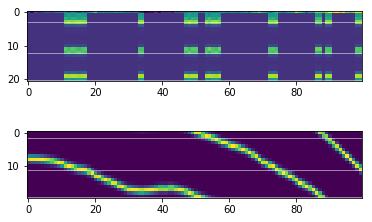

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

input, target, landmarks = createBatch(1, 100, 21, 20)

fig,ax = plt.subplots(2,1)
ax[0].imshow(input[0,:,:].data.numpy().T)
ax[1].imshow(target[0,:,:].data.numpy().T)
for landmark in landmarks[0]:
    ax[0].axhline((landmark+pi)/(2*pi) * 20 + 1, color="white", alpha=0.5, linewidth=1)
    ax[1].axhline((landmark+pi)/(2*pi) * 20, color="white", alpha=0.5, linewidth=1)

plt.show()

## Train the network.

In [3]:
N_INPUT = 80
N_HIDDEN = 128
N_OUTPUT = 70

N_STEPS = 100
N_TRIALS = 10
N_EPOCHS = 100000

network = Network(N_INPUT, N_HIDDEN, N_OUTPUT)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters())
losses = []

In [ ]:
from tqdm import tqdm
for epoch in tqdm(range(N_EPOCHS)):
    
    input, target, landmarks = createBatch(N_TRIALS, N_STEPS, N_INPUT, N_OUTPUT)
    
    optimizer.zero_grad()
    output = network(input)
    
    loss = criterion(output, target)
    loss.backward()
    losses.append(loss.item())
    # torch.nn.utils.clip_grad_norm_(network.parameters(), 100)
    #if epoch%100==0:
    #    print epoch, loss.item()
    optimizer.step()

 66%|██████▌   | 65715/100000 [2:23:57<1:16:38,  7.46it/s]

In [ ]:
#input, target, landmarks = createBatch(N_TRIALS, N_STEPS, N_INPUT, N_OUTPUT)
#out = network(input)
plt.imshow(np.max(out[0].data.numpy().T),axis=0)
plt.show()
plt.imshow(input[0].data.numpy().T)
plt.show()
plt.imshow(target[0,:,:].data.numpy().T)
for landmark in landmarks[0]:
    plt.axhline((landmark+pi)/(2*pi) * N_OUTPUT, color="white", alpha=0.5, linewidth=1)

